### Setup & Initialization

In [1]:
import re
import os
import sys
import ast
import yaml
import json
import time
import datetime

import numpy as np
from getpass import getpass
from tqdm.notebook import tqdm
from datasets import load_dataset
from contextlib import contextmanager

from openai import OpenAI, APIStatusError, RateLimitError, APIConnectionError

In [2]:
SAMPLE_SIZE = 50
REPEAT_ANNOTATION = 10

In [3]:
# Specifying path to the necessary files and folders
PATH_TO_SRC = os.path.abspath('../../../')

# Where to get annotation examples for the prompt
ANNOTATION_EXAMPLES_PATH = os.path.join(PATH_TO_SRC, 'src/query/ner_examples_all_languages_for_batch.json')
CONFIG_PATH = os.path.join(PATH_TO_SRC, "settings/config.yml")
# Folder to save annotations
RESULTS_PATH = os.path.join(PATH_TO_SRC, 'data/foundation_model_selection/gpt_4_turbo_batch_size_2')

In [4]:
@contextmanager
def extend_sys_path(path):
    if path not in sys.path:
        # Append the path to sys.path
        sys.path.append(path)
    try:
        # Execute code inside the 'with' statement
        yield
    finally:
        # Remove the path from sys.path
        if path in sys.path:
            sys.path.remove(path)

In [5]:
# Temporarily add module_path and import functions
with extend_sys_path(PATH_TO_SRC):
    from src.data.sample import sample_for_model_selection
    from src.query.query_gpt import add_annotation_examples_for_batch
    from src.query.prompts import MAIN_PROMPT_FOR_BATCH
    from src.utils.utils import calculate_consistency_score, get_api_usage

In [6]:
# Init openai client
openai_client = OpenAI(api_key=getpass("OPENAI API key:"))

In [8]:
# Reading config file
config = yaml.safe_load(open(os.path.join(PATH_TO_SRC, "settings/config.yml")))

# Load indx-to-label_name mapping
label_mapping = config['label_mapping']

### Utils

In [9]:
def ask_gpt_short(tokens, language, examples, openai_client,
                  user_prompt, temperature, model,
                  system_prompt=None, max_tokens=1000):
    
    inputs = str(tokens)

    if system_prompt is None:
        system_prompt = f"You are a named entity labelling expert in {language} language."

    # Format user prompt
    user_prompt = user_prompt.format(language=language, inputs=inputs, examples=examples)

    # Save query params
    query_params = {
        'model': model,
        'temperature': temperature,
        'messages': [{"role": "system", "content": system_prompt},
                     {"role": "user", "content": user_prompt}],
        'max_tokens': max_tokens,
    }

    if model == 'gpt-4-1106-preview' or model == 'gpt-4-0125-preview':  
        query_params['response_format'] = {"type": "json_object"}

    try:
        # Query the model
        response = openai_client.chat.completions.create(**query_params)
        # Extract model answer
        answer = response.choices[0].message.content
        return answer

    except APIConnectionError as e:
        raise Exception(f"The server could not be reached: {e.__cause__}")
    except RateLimitError as e:
        raise Exception(f"A 429 status code was received: {e}")
    except APIStatusError as e:
        raise Exception(f"Non-200-range status code received: {e.status_code}, {e.response}")


In [1]:
def repeat_annotation(n_repeat=10, **ask_gpt_kwargs):
    # Counters
    no_json_counter = 0  # No json was provided by the model
    incorrect_format_counter = 0  # Number of records parsed in the incorrect format 

    # Results
    ner_tokens_dict = {}
    ner_tokens_dict['record_0'] = []
    ner_tokens_dict['record_1'] = []

    for i in tqdm(range(n_repeat)):
        # Send request to a model
        model_response = ask_gpt_short(**ask_gpt_kwargs)

        # Newer models provide json
        try:
            outputs = json.loads(model_response)['output']
            ner_tokens_dict['record_0'].append(outputs['record_0'])
            ner_tokens_dict['record_1'].append(outputs['record_1'])
        except Exception as e:
            print('#'*80)
            print(e)
            print(model_response)
            incorrect_format_counter += 1
            continue

    print(f'Number of model responses without json: {no_json_counter}')
    print(f'Number of model responses with incorrect formatting: {incorrect_format_counter}')
    return ner_tokens_dict

### Querying (zul)

In [11]:
LANGUAGE = 'zul'

language_name = config['languages_names'][LANGUAGE]
language_name

'Zulu'

In [12]:
# Loading dataset from HuggingFace
data = load_dataset(config['dataset'], LANGUAGE)

  0%|          | 0/3 [00:00<?, ?it/s]

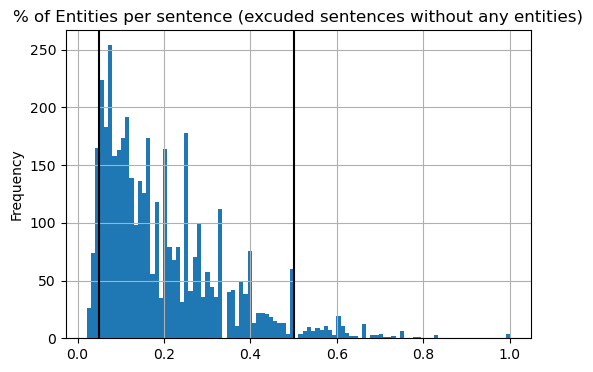

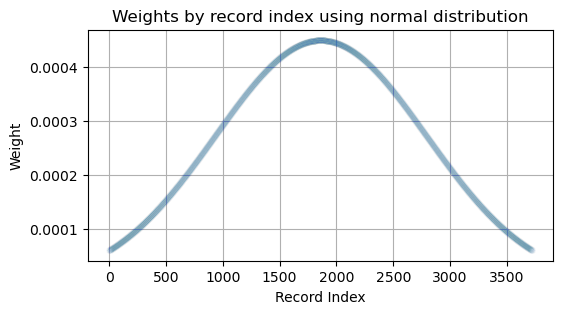

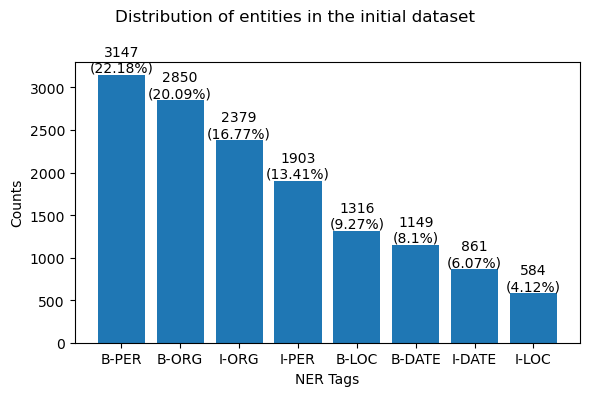

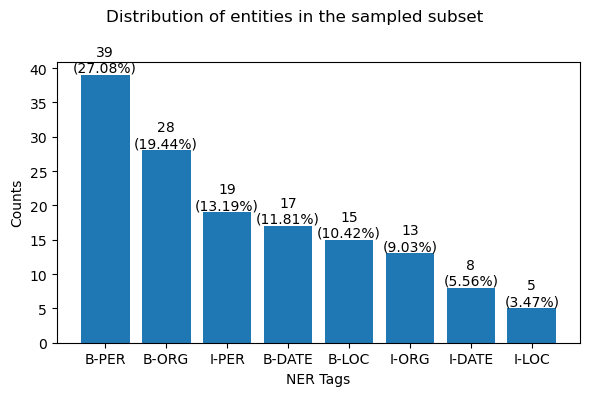

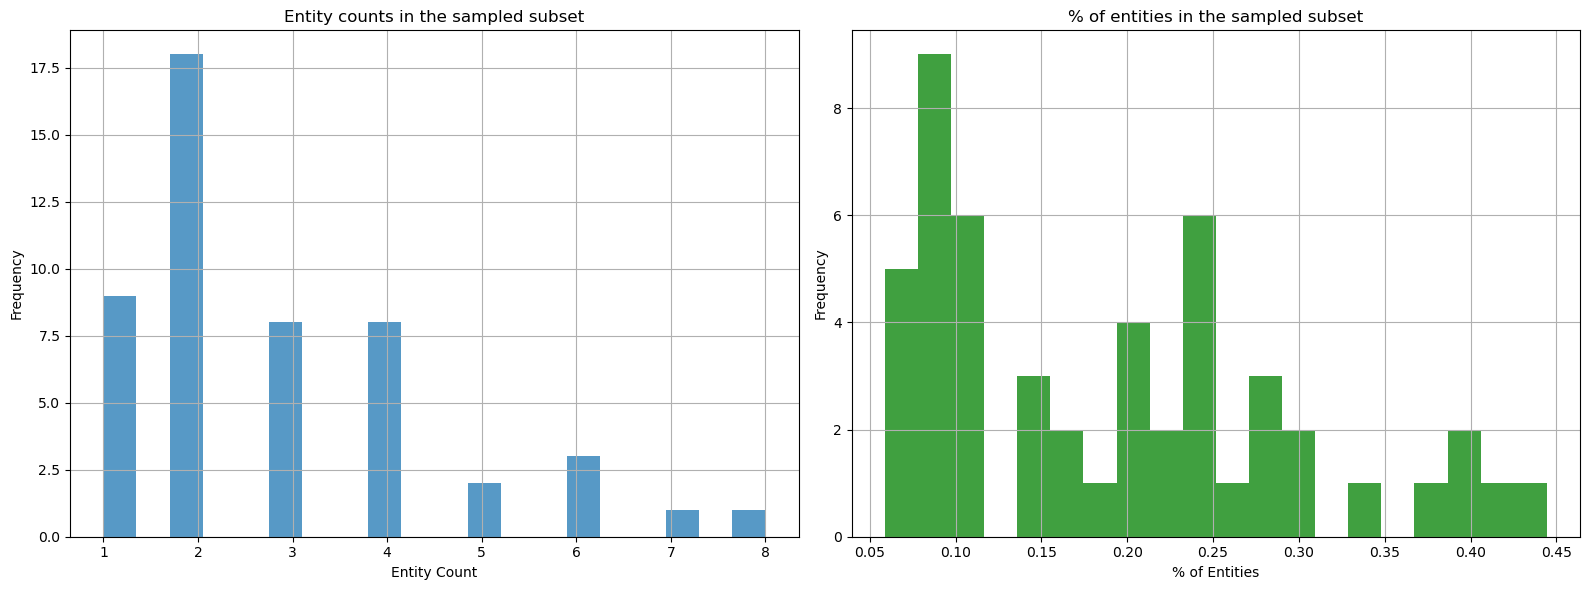

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'entity_count', 'num_labels', '% of entities'],
    num_rows: 50
})

In [13]:
sampled_subset = sample_for_model_selection(data, label_mapping, n_samples=SAMPLE_SIZE, verbose=True)
sampled_subset

In [14]:
ask_gpt_params = {
    'language': language_name,
    'examples': add_annotation_examples_for_batch(ANNOTATION_EXAMPLES_PATH, language_name),
    'openai_client': openai_client,
    'user_prompt': MAIN_PROMPT_FOR_BATCH,
    'model': 'gpt-4-0125-preview', 
    'temperature': config['foundation_model']['temperature']
}

In [15]:
ask_gpt_params['temperature']

0.1

In [16]:
gpt_annotations = {}
consistency_scores = []

# Measure how much time it takes to get all inferences
start = time.time()


for index in range(len(sampled_subset)//2):
    # Calculate index of first item from the couple
    i = 2 * index

    print(f'\nSample {i+1} and {i+2}:')

    record_0 = sampled_subset[i]
    record_1 = sampled_subset[i+1]
    
    try: 
        # Extract ground truth
        ground_truth_labels_record_0 = [label_mapping[t] for t in record_0['ner_tags']]
        ground_truth_labels_record_1 = [label_mapping[t] for t in record_1['ner_tags']]
        
        # Extract tokens from current record
        tokens = {}
        tokens['record_0'] = record_0['tokens']
        tokens['record_1'] = record_1['tokens']

        ask_gpt_params['tokens'] = tokens

        # Query the model
        new_labels_gpt = repeat_annotation(n_repeat=REPEAT_ANNOTATION,
                                                **ask_gpt_params)
        
        # Save annotations
        gpt_annotations[f'record_{i}'] = {}
        gpt_annotations[f'record_{i}']['pred'] = new_labels_gpt['record_0']
        gpt_annotations[f'record_{i}']['true'] = ground_truth_labels_record_0
        gpt_annotations[f'record_{i}']['tokens'] = record_0['tokens']
        
        gpt_annotations[f'record_{i+1}'] = {}
        gpt_annotations[f'record_{i+1}']['pred'] = new_labels_gpt['record_1']
        gpt_annotations[f'record_{i+1}']['true'] = ground_truth_labels_record_1
        gpt_annotations[f'record_{i+1}']['tokens'] = record_1['tokens']

        # Calculate consistency score
        consistency_record_0 = calculate_consistency_score(new_labels_gpt['record_0'],
                                                    ground_truth_labels_record_0)
        gpt_annotations[f'record_{i}']['consistency'] = consistency_record_0
        consistency_scores.append(consistency_record_0)

        consistency_record_1 = calculate_consistency_score(new_labels_gpt['record_1'],
                                                    ground_truth_labels_record_1)
        gpt_annotations[f'record_{i+1}']['consistency'] = consistency_record_1
        consistency_scores.append(consistency_record_1)
    
    except Exception as e:
        print(e)
        continue

end = time.time()
print('Execution time: ', end - start, 's')  


Sample 1 and 2:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 3 and 4:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 5 and 6:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 7 and 8:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 9 and 10:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 11 and 12:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 13 and 14:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 15 and 16:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 17 and 18:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 19 and 20:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 21 and 22:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 23 and 24:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 25 and 26:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 27 and 28:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 29 and 30:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 31 and 32:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 33 and 34:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 35 and 36:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 37 and 38:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 39 and 40:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 41 and 42:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 43 and 44:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 45 and 46:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 47 and 48:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0

Sample 49 and 50:


  0%|          | 0/10 [00:00<?, ?it/s]

Number of model responses without json: 0
Number of model responses with incorrect formatting: 0
Execution time:  3703.964893102646 s


In [17]:
# Overall consistency is calculated by averaging individual scores
gpt_annotations['overall_consistency'] = np.mean(consistency_scores)

In [18]:

print("Number of samples that model didn't generate any output for them: ", consistency_scores.count(0))

print("Overall consistency on all samples: ", gpt_annotations['overall_consistency'])

Number of samples that model didn't generate any output for them:  0
Overall consistency on all samples:  93.09700000000001


In [19]:
with open(os.path.join(RESULTS_PATH, f'{LANGUAGE}.json'), 'w') as file:
    json.dump(gpt_annotations, file, indent=4)